In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import smart_resize
import matplotlib.pyplot as plt
import numpy.random as rng
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as tf_reg
import tensorflow.keras.backend as K

## Step 1: load images from the different servant classes

In [2]:
path = "./siemese_data" # in this case we can get away with grayscale data as well 
x = []  # x is the data we have (20, 3, 124, 124) (assuming its gray scale)
y = [] # the labels (60,1) all the images for one letter have the same label 
curr_y = 0 # the label of the image
img_size = (124, 124)
for servant in os.listdir(path):
    if not "." in servant:
        print("loading: ", servant)
        print("label: ", curr_y)
        serv_path = os.path.join(path, servant)
        serv_imgs = []
        for file in os.listdir(serv_path):
            if not ".DS" in file:
                img_path = os.path.join(serv_path, file)
                img = Image.open(img_path).convert('RGB')
                img = np.array(img)
                img = tf.image.rgb_to_grayscale(img)
                img = smart_resize(img, img_size) / 255
                serv_imgs.append(np.squeeze(img))
                y.append(curr_y)
        x.append(np.stack(serv_imgs))
        curr_y += 1 

x = np.stack(x)
y = np.vstack(y)

print(x.shape, type(x))
print(y.shape)

loading:  jalter
label:  0
loading:  nito
label:  1
loading:  dantes
label:  2
loading:  mash
label:  3
loading:  ishtar_summer
label:  4
loading:  shiki
label:  5
loading:  ozy
label:  6
loading:  saber
label:  7
loading:  hokusai
label:  8
loading:  cu
label:  9
loading:  eresh
label:  10
loading:  raikou
label:  11
loading:  regend
label:  12
loading:  karna
label:  13
loading:  ishtar
label:  14
loading:  musashi
label:  15
loading:  napoleon
label:  16
loading:  waver
label:  17
loading:  tamamo
label:  18
loading:  wu
label:  19
(20, 3, 124, 124) <class 'numpy.ndarray'>
(60, 1)


(-0.5, 123.5, 123.5, -0.5)

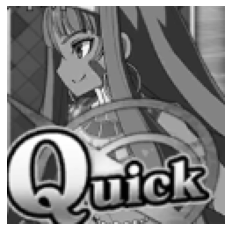

In [3]:
plt.figure()
plt.imshow(x[1][2], cmap='gray')
plt.axis("off")

## Step 2: map the images to a binary, siemese classification task 

In [32]:
# we want a data set where each element is ((img1, img2), label)
# label is 0 if they are different, 1 if they are the same servant

# so we have to create pairs of images, with a label, then we will turn that processed array into a dataset
# we want to have a balanced dataset, so create pairs of half same, half different 
# note to self don't use lists cuz tf/ keras no like 
# let's try to make a dataset from a python generator, taking the images and labels as input  
def get_siemese_batch(batch_size, x): 
    n_classes, n_examples, w, h = x.shape
    
    # randomly select servants to use in the batch
    servants = rng.choice(n_classes, size=(batch_size,), replace=False)
    
    # 2 empty arrays for input image batch
    pairs=[np.zeros((batch_size, h, w, 1)) for i in range(2)]
    # 1 array for the target 
    labels = np.zeros((batch_size,))
    labels[batch_size//2:] = 1 # make half of the labels different, half the same
    
    for i in range(batch_size):
        servant = servants[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i, :, : ,:] = x[servant, idx_1].reshape(w, h, 1) 
        
        # if we are in the second half of the batch, generate from same servant
        if i >= batch_size //2: 
            servant_2 = servant 
        else:
            servant_2 = (servant + rng.randint(1, n_classes)) % n_classes
            
        idx_2 = rng.randint(0, n_examples)
        pairs[1][i, :, :, :] = x[servant_2, idx_2].reshape(w, h, 1)
        
    return pairs, labels

# the actual generator function just wraps the get batch function
def batch_gen(batch_size, x):
    while True: 
        pairs_in, labels = get_siemese_batch(batch_size, x)
        yield (pairs_in, labels)


2
[0. 1.]


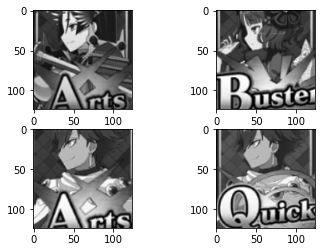

In [34]:
## check that it is working nicely 
count = 0 
for pairs, labels in batch_gen(2, x):
    print(len(pairs))
    print(labels)
    plt.figure()
    ax = plt.subplot(2, 2, 1)
    
    ax = plt.subplot(2, 2 , 2)
    plt.imshow(pairs[1][0].reshape(124,124), cmap="gray")
    ax = plt.subplot(2, 2, 3)
    plt.imshow(pairs[0][1].reshape(124,124), cmap="gray")
    ax = plt.subplot(2, 2 , 4)
    plt.imshow(pairs[1][1].reshape(124,124), cmap="gray")
    count += 1
    break

In [21]:
gen = batch_gen(3, x)
print(type(next(gen)[0]))

<class 'list'>


## Step 3 create the siemese network

In [56]:
# if performance isn't poggers we can tweak this 

def simple_siemese_net(input_shape):
    # two inputs for the image pair 
    left_in = tf.keras.Input(input_shape)
    right_in = tf.keras.Input(input_shape)
    
    # set up the convolution network for feature extraction (shared weights)
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=(10,10), activation="relu", 
                           input_shape=input_shape,
                           kernel_regularizer=tf_reg.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=128, kernel_size=(8,8), activation="relu",
                           kernel_regularizer=tf_reg.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=128, kernel_size=(4,4), activation="relu",
                           kernel_regularizer=tf_reg.l2(2e-4),
                           ))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=256, kernel_size=(4,4), activation="relu",
                           kernel_regularizer=tf_reg.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation="sigmoid",
                   kernel_regularizer=tf_reg.l2(1e-3)))
    
    # get the outputs for the pair of inputs
    encoded_l = model(left_in)
    encoded_r = model(right_in)
    
    # custom layer to computer absolute difference between encodings 
    L1_layer = layers.Lambda(lambda t:K.abs(t[0] - t[1]))
    abs_diff = L1_layer([encoded_l, encoded_r])
    
    prediction = layers.Dense(1, activation="sigmoid")(abs_diff)
    
    siamese_net = tf.keras.Model(inputs=[left_in, right_in], outputs=prediction)
    
    return siamese_net

In [57]:
input_shape = (124, 124, 1)
model = simple_siemese_net(input_shape)
model.summary()


Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 124, 124, 1) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 124, 124, 1) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         18099008    input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 4096)         0           sequential_5[0][0]   

In [58]:
print(len(pairs))
preds = model.predict_on_batch(pairs)
preds

2


array([[0.5006197 ],
       [0.5005489 ],
       [0.500039  ],
       [0.5005023 ],
       [0.50069773],
       [0.5002783 ],
       [0.5001027 ],
       [0.5003328 ],
       [0.50013375],
       [0.500461  ],
       [0.5       ],
       [0.5       ],
       [0.50042874],
       [0.49968186],
       [0.5004856 ],
       [0.49960563]], dtype=float32)

## Step 4: create a custom training loop 

In [59]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=5e-4)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])


In [63]:
# evaluation function to see accuracy 

def eval_acc(model, batch_size, generator):
    n_correct = 0
    pairs, targets = next(generator)
    preds = model.predict_on_batch(pairs)
    for i in range(batch_size):
        if preds[i] <= 0.5:
            if targets[i] == 0:
                n_correct += 1
        else:
            if targets[i] == 1:
                n_correct += 1
    
    return n_correct/ batch_size

gen = batch_gen(16, x)
acc = eval_acc(model, 16, gen)
print(acc)

[0.968797]
[0.5111465]
[0.77157515]
[0.5111465]
[0.5111465]
[0.54466784]
[0.7330549]
[0.84699893]
1.0


0.5 makes sense... since the model is untrained and there are 2 options 


In [61]:
# now lets define the actual training loop 
evaluate_every = 320
loss_every = 160
batch_generator = batch_gen(16, x)
best = 0 
i = 0
while(1600):
    pairs, labels = next(batch_generator)
    loss=model.train_on_batch(pairs, labels)
    loss = sum(loss)/len(loss)
    if i % evaluate_every == 0:
        val_acc = eval_acc(model, 16, batch_generator)
        if val_acc > best:
            print("saving val_acc: ", best)
            model.save('curr_best')
            best=val_acc
    if i % loss_every == 0:
        print("iteration {0}, training loss: {1:.2f},".format(i,loss))
    
    i += 16

saving val_acc:  0
INFO:tensorflow:Assets written to: curr_best/assets
iteration 0, training loss: 2.56,
iteration 160, training loss: 1.90,
iteration 320, training loss: 1.50,
iteration 480, training loss: 1.24,
iteration 640, training loss: 1.04,
iteration 800, training loss: 1.01,
iteration 960, training loss: 0.88,
iteration 1120, training loss: 0.89,
iteration 1280, training loss: 0.83,
iteration 1440, training loss: 0.81,
iteration 1600, training loss: 0.82,


KeyboardInterrupt: 

In [53]:
model_updated = tf.keras.models.load_model("curr_best")

In [64]:
acc = eval_acc(model_updated, 16, batch_generator)
print(acc)

[0.94456077]
[0.85447973]
[0.88243955]
[0.88879037]
[0.97545373]
[0.9869442]
[0.97196925]
[0.91318476]
1.0


In [87]:
# lets use the model to do some evaluations
images = []
new_imgs = "./siemese_data/val_"
for file in os.listdir(new_imgs):
    if ".DS" not in file:
        img_path = os.path.join(new_imgs, file)
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        img = tf.image.rgb_to_grayscale(img)
        img = smart_resize(img, img_size) / 255
        images.append(np.array(img))

print(images[0].shape)


(124, 124, 1)


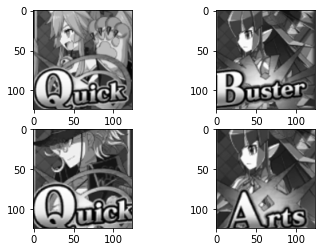

In [88]:
plt.figure()
 
ax = plt.subplot(2, 2, 1)
plt.imshow(images[0].reshape(124,124), cmap="gray")
ax = plt.subplot(2, 2 , 2)
plt.imshow(images[1].reshape(124,124), cmap="gray")
ax = plt.subplot(2, 2, 3)
plt.imshow(images[2].reshape(124,124), cmap="gray")
ax = plt.subplot(2, 2, 4)
plt.imshow(images[3].reshape(124,124), cmap="gray")

different servant, with confidence of:  0.9999755024909973


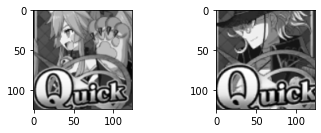

In [91]:
pred = model_updated([images[0].reshape((1, 124, 124 ,1)), images[2].reshape((1, 124, 124 ,1))])
if pred <= 0.5:
    print("different servant, with confidence of: ", float(1-pred))
else:
    print("same servant, with confidence of: ", float(pred))
plt.figure()
ax = plt.subplot(2, 2, 1)
plt.imshow(images[0].reshape(124,124), cmap="gray")
ax = plt.subplot(2, 2 , 2)
plt.imshow(images[2].reshape(124,124), cmap="gray")